In [1]:
import glob
import json
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import distribute as dist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

2024-04-04 13:11:17.877468: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 13:11:20.690481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
print(tf.__version__)

In [2]:
from src.datagenerator import DataGenerator

In [3]:
params = {
    "path": "../3dIT/measurements/datapool/",
    "mean_path": "../3dIT/measurements/datameans/",
    "eit_dim": 4096,
    "supervised": "material",  # "diameter" or "material"
    "batch_size": 128,
    "shuffle": True,
}

idx = np.arange(0, len(os.listdir(params["path"])))
np.random.shuffle(idx)

training_generator = DataGenerator(idx[:10_000], **params)

In [4]:
X, Y = training_generator[0]

In [5]:
print(X.shape, Y.shape)

(128, 64, 64, 1) (128, 1)


In [6]:
Xscaler = tf.keras.layers.Normalization(axis=2)


def model(input_shape=(64, 64, 1), latent_dim=3, kernel=9):
    mapper_input = tf.keras.layers.Input(shape=input_shape)

    # normalize input data
    x = Xscaler(mapper_input)

    # convolutional layers
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Activation("elu")(x)
    # x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2, 4))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    # x = Dense(latent_dim, activation="elu")(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)

    return Model(mapper_input, mapper_output)

In [7]:
opt = Adam(learning_rate=1e-3)
model = model(latent_dim=1, kernel=5)
model.compile(optimizer=opt, loss="mse")

model.summary()

2024-04-04 13:11:35.261617: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 64, 64, 1)      │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 16, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 4, 8)       │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 1, 16)       │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 1, 16)       │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,642 (45.48 KB)

 Trainable params: 11,513 (44.97 KB)

 Non-trainable params: 129 (520.00 B)

In [8]:
# es = EarlyStopping(
#    monitor="val_loss", mode="min", patience=10, restore_best_weights=True
# )
# Xscaler.adapt(X)

history = model.fit(training_generator, batch_size=128, epochs=10)

Epoch 1/10


/home/jath/.conda/envs/TF2_12/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-04 13:11:51.807704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8


 1/78 ━━━━━━━━━━━━━━━━━━━━ 26:21 21s/step - loss: 0.5304

2024-04-04 13:11:59.383015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


78/78 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 0.2676
Epoch 2/10


2024-04-04 13:14:54.545439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8


 1/78 ━━━━━━━━━━━━━━━━━━━━ 16:23 13s/step - loss: 0.0669

2024-04-04 13:14:57.175859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


78/78 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - loss: 0.0722
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - loss: 0.0703
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.0619
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - loss: 0.0513
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - loss: 0.0409
Epoch 7/10


2024-04-04 13:24:04.426789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


 1/78 ━━━━━━━━━━━━━━━━━━━━ 17:01 13s/step - loss: 0.0361

2024-04-04 13:24:05.914542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


78/78 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - loss: 0.0378
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - loss: 0.0344
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - loss: 0.0329
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - loss: 0.0296


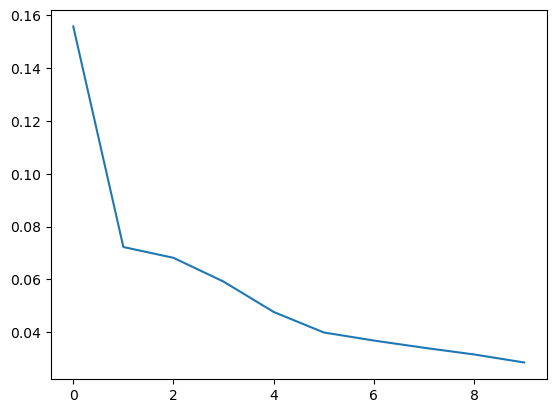

In [9]:
plt.plot(history.history["loss"])

In [11]:
model.save_weights('models/material_mapper.weights.h5')

## Test the models performance

In [ ]:
training_generator = DataGenerator(idx[10_000:20_000], **params)